# COGS 118B - Final Project Results & Discussion

# American Sign Language Recognition

# Names

- Allen Phu
- Kevin Yu
- Saksham Rai
- Rodrigo Lizaran-Molina

# Results/Discussion

You may have done tons of work on this. Not all of it belongs here. 

Reports should have a __narrative__. Once you've looked through all your results over the quarter, decide on one main point and 2-4 secondary points you want us to understand. Include the detailed code and analysis results of those points only; you should spend more time/code/plots on your main point than the others.

If you went down any blind alleys that you later decided to not pursue, please don't abuse the TAs time by throwing in 81 lines of code and 4 plots related to something you actually abandoned.  Consider deleting things that are not important to your narrative.  If its slightly relevant to the narrative or you just want us to know you tried something, you could keep it in by summarizing the result in this report in a sentence or two, moving the actual analysis to another file in your repo, and providing us a link to that file.

### Main Takeaways
After working through this project, we've realized that, ultimately, unsupervised algorithms were not that great for this dataset. This checks out with what we suspected before we began: unsupervised algorithms perform far worse than supervised algorithms for image recognition. 

While our supervised models such as SVM and CNN gave us great results, our unsupervised algorithms such as Gaussian Mixture Models and K-Means gave us poor performance. Unsurprisingly, the CNN gave us the best performance, with SVM coming in at second. This was expected, as CNN algorithms already have a reputation for being strong algorithms for image processing.

# Discussion

### Interpreting the result

OK, you've given us quite a bit of tech informaiton above, now its time to tell us what to pay attention to in all that.  Think clearly about your results, decide on one main point and 2-4 secondary points you want us to understand. Highlight HOW your results support those points.  You probably want 2-5 sentences per point.

## All Library Imports

In [1]:
# basic data utils
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
pal = sns.color_palette("hls", 10)

# Dimension reduction and clustering tools
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.svm import SVC
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

# Metrics for how good a clustering does
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, classification_report, silhouette_score, accuracy_score, rand_score, confusion_matrix

from scipy import stats

## Data Import

In [2]:
train = pd.read_csv("data/sign_mnist_train.csv")
test = pd.read_csv("data/sign_mnist_test.csv")

extract_test = test.drop(columns="label")
test_data = extract_test.values
test_labels = test.get("label")

extract_forkmeans = train.drop(columns="label")
data = extract_forkmeans.values

# Analysis

We decided to do some previous analysis of our data to give us an idea of what we are working with

In [7]:
print(f'Shape of train data: {train.shape}')
print(f'Shape of test data: {test.shape}')

label_test = test['label']
label_train = train['label']
train_data = train.drop('label',axis=1)
test_data = test.drop('label',axis=1)

# Display descriptive statistics for train dataset
print(f'Train descriptive stats {train.label.describe()}')
# Display descriptive statistics for test dataset
print(f'\nTest descriptive stats {test.label.describe()}')

Shape of train data: (27455, 785)
Shape of test data: (7172, 785)
Train descriptive stats count    27455.000000
mean        12.318813
std          7.287552
min          0.000000
25%          6.000000
50%         13.000000
75%         19.000000
max         24.000000
Name: label, dtype: float64

Test descriptive stats count    7172.000000
mean       11.247351
std         7.446712
min         0.000000
25%         4.000000
50%        11.000000
75%        18.000000
max        24.000000
Name: label, dtype: float64


Our data for the "train" and "test" have very similar values. The only difference is the quantity of rows in each data. This make sense since our train data has to be bigger than our test data to train our models.

Below, we can visualize the distribution of both datasets

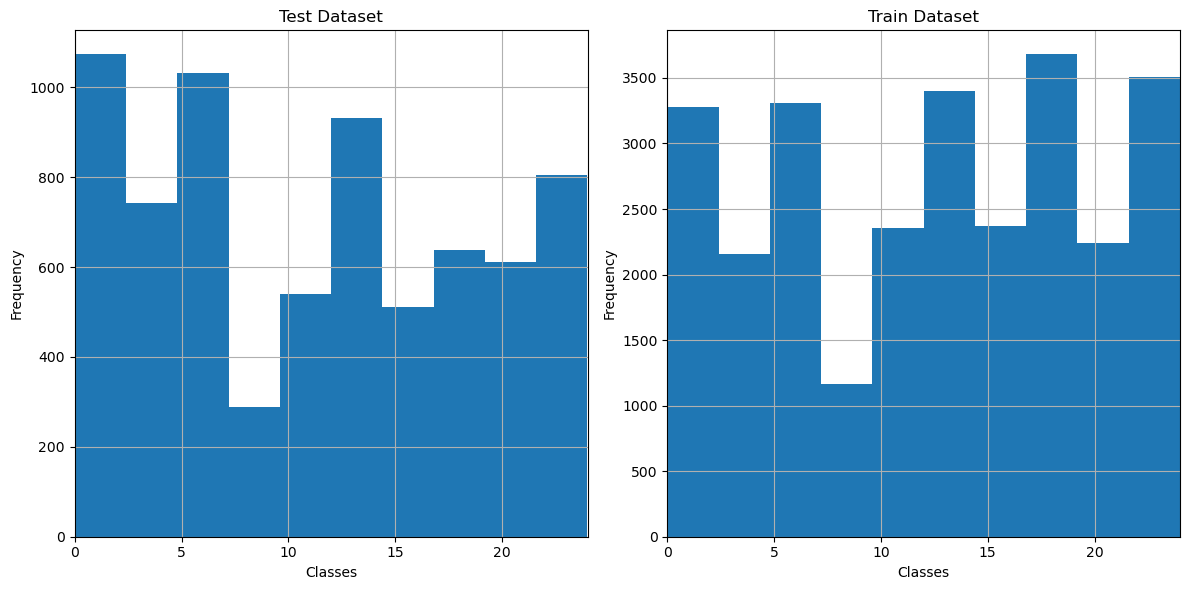

In [8]:
# Create a figure and axes for subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot histogram and display descriptive statistics for test dataset
test.label.hist(ax=axes[0])
axes[0].set_title('Test Dataset')
axes[0].set_xlabel('Classes')
axes[0].set_ylabel('Frequency')
axes[0].set_xlim(0,24)
axes[0].grid(True)

# Plot histogram and display descriptive statistics for train dataset
train.label.hist(ax=axes[1])
axes[1].set_title('Train Dataset')
axes[1].set_xlabel('Classes')
axes[1].set_ylabel('Frequency')
axes[1].set_xlim(0,24)
axes[1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

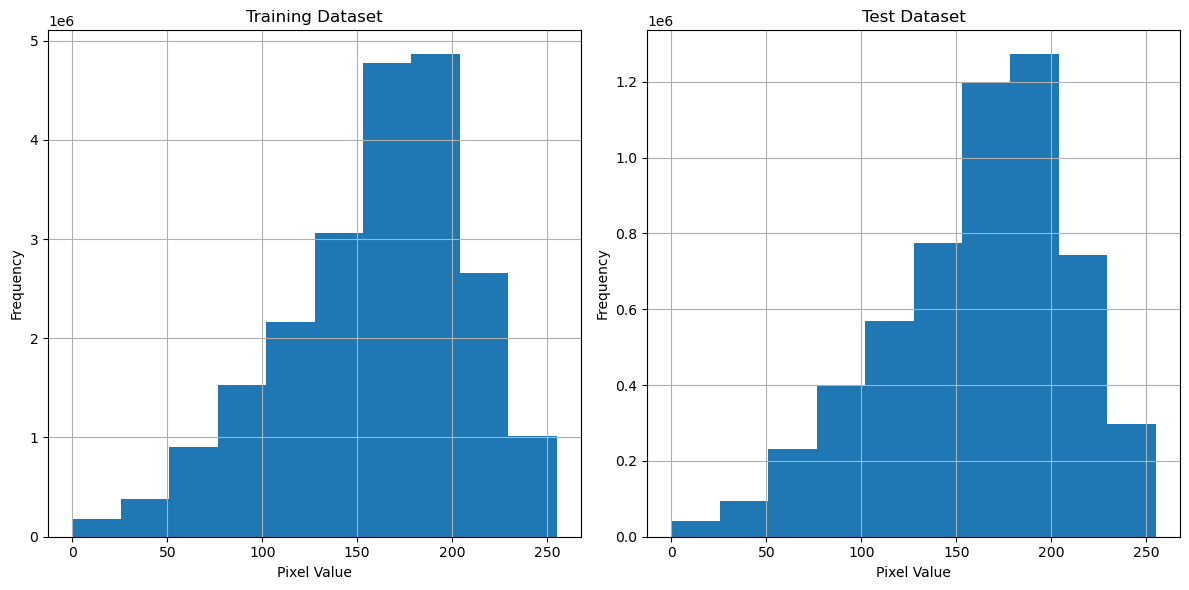

In [9]:
# Concatenate pixel values from both train and test datasets
pix_train = pd.Series(train_data.values.reshape(-1))
pix_test = pd.Series(test_data.values.reshape(-1))

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot histogram and display descriptive statistics for training dataset
pix_train.hist(ax=axes[0])
axes[0].set_title('Training Dataset')
axes[0].set_xlabel('Pixel Value')
axes[0].set_ylabel('Frequency')

# Plot histogram for test dataset
pix_test.hist(ax=axes[1])
axes[1].set_title('Test Dataset')
axes[1].set_xlabel('Pixel Value')
axes[1].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

On these graphs, we wanted to observe and visualize the value of the pixels of both datasets. As observe, both are equally distributed holding most pixel values between 150-225

Train pixel descriptive stats count    2.152472e+07
mean     1.592910e+02
std      4.876951e+01
min      0.000000e+00
25%      1.300000e+02
50%      1.670000e+02
75%      1.940000e+02
max      2.550000e+02
dtype: float64

Test pixel descriptive stats count    5.622848e+06
mean     1.605711e+02
std      4.904256e+01
min      0.000000e+00
25%      1.300000e+02
50%      1.690000e+02
75%      1.960000e+02
max      2.550000e+02
dtype: float64


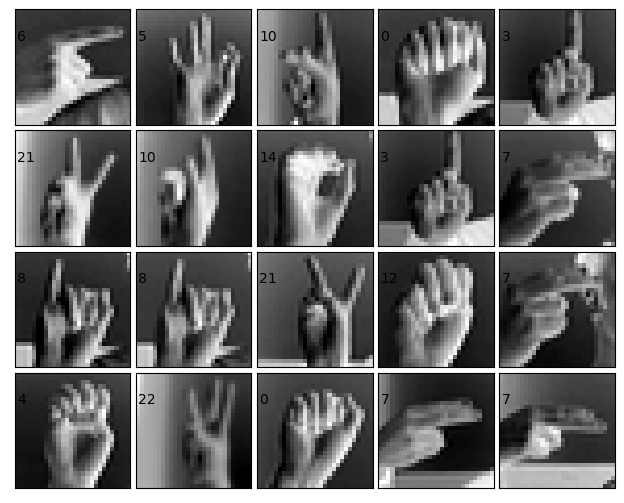

In [11]:
# Display descriptive statistics for train dataset
print(f'Train pixel descriptive stats {pix_train.describe()}')
# Display descriptive statistics for test dataset
print(f'\nTest pixel descriptive stats {pix_test.describe()}')

# examples of the raw data

fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(20):
    ax = fig.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    # data is 28 x 28 pixels, grayscale
    ax.imshow(test_data.loc[i].to_numpy().reshape(28,28), cmap=plt.cm.binary, interpolation='nearest')
    # label the image with the target value
    ax.text(0, 7, str(test.label.loc[i]))

We also printed out the descriptive statistics of the graphs as well as printing out and visualizing the raw data to give us an idea how these images look like

### CNN - Results
Our CNN gave us, by far, the best results. As has been stated before, supervised algorithms are better for image recognition. CNNs in particular are excellent (and mainly used) for image recognition, so the results didn't surprise us all too much. 

In [14]:
# initialize model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  

cuda:0


In [15]:
#(batch_size, 1, 28, 28)


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 15, 3, 1, 1)
        self.pool = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(15, 20, 3,1,1)
        self.conv3 = nn.Conv2d(20, 20, 3,1,1)
        self.fc1 = nn.Linear(180, 100)
        
        self.fc3 = nn.Linear(100, 26)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc3(x)
        
        return x
    
    
net = Net()     
net.to(device)  
        

Net(
  (conv1): Conv2d(1, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(15, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=180, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=26, bias=True)
)

In [16]:
loss_func = nn.CrossEntropyLoss()  
opt = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) 

In [17]:
labels = np.array(train.get("label"))

In [18]:
# train cnn
data_tensor = torch.Tensor(data).view(-1, 1, 28, 28)  
labels_tensor = torch.Tensor(labels).long().squeeze()  


dataset = TensorDataset(data_tensor, labels_tensor)
data_loader = DataLoader(dataset, batch_size=4, shuffle=True)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

num_epochs = 10  
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(data_loader, 0):
        
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        
        optimizer.zero_grad()

        
        outputs = net(inputs)

        
        loss = criterion(outputs, labels)

        
        loss.backward()
        optimizer.step()

        
        running_loss += loss.item()
        if i % 100 == 99:  
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 3.307
[1,   200] loss: 3.117
[1,   300] loss: 2.698
[1,   400] loss: 2.308
[1,   500] loss: 2.029
[1,   600] loss: 1.773
[1,   700] loss: 1.596
[1,   800] loss: 1.471
[1,   900] loss: 1.295
[1,  1000] loss: 1.166
[1,  1100] loss: 1.162
[1,  1200] loss: 1.143
[1,  1300] loss: 0.885
[1,  1400] loss: 0.894
[1,  1500] loss: 0.820
[1,  1600] loss: 0.708
[1,  1700] loss: 0.761
[1,  1800] loss: 0.764
[1,  1900] loss: 0.507
[1,  2000] loss: 0.576
[1,  2100] loss: 0.530
[1,  2200] loss: 0.593
[1,  2300] loss: 0.437
[1,  2400] loss: 0.408
[1,  2500] loss: 0.545
[1,  2600] loss: 0.431
[1,  2700] loss: 0.438
[1,  2800] loss: 0.407
[1,  2900] loss: 0.438
[1,  3000] loss: 0.378
[1,  3100] loss: 0.319
[1,  3200] loss: 0.361
[1,  3300] loss: 0.294
[1,  3400] loss: 0.247
[1,  3500] loss: 0.294
[1,  3600] loss: 0.261
[1,  3700] loss: 0.282
[1,  3800] loss: 0.319
[1,  3900] loss: 0.201
[1,  4000] loss: 0.199
[1,  4100] loss: 0.189
[1,  4200] loss: 0.209
[1,  4300] loss: 0.203
[1,  4400] 

In [19]:
# get accuracy and classification report
test_data_tensor = torch.Tensor(test_data).view(-1, 1, 28, 28)
test_labels_tensor = torch.Tensor(test_labels).long().squeeze()

test_dataset = TensorDataset(test_data_tensor, test_labels_tensor)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

net.eval()  
correct = 0
total = 0

true_labels = []
predicted_labels = []

with torch.no_grad():  
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        
        outputs = net(images)

        
        _, predicted = torch.max(outputs.data, 1)

        
        total += labels.size(0)

        
        correct += (predicted == labels).sum().item()
        
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

accuracy = 100 * correct / total
print(f'Accuracy : {accuracy:.2f}%')

# conv to numpy array
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

print(classification_report(true_labels, predicted_labels))

Accuracy : 91.79%
              precision    recall  f1-score   support

           0       0.93      1.00      0.97       331
           1       0.96      1.00      0.98       432
           2       1.00      1.00      1.00       310
           3       0.99      0.92      0.95       245
           4       0.98      0.98      0.98       498
           5       0.94      1.00      0.97       247
           6       1.00      0.80      0.89       348
           7       0.83      1.00      0.90       436
           8       1.00      0.96      0.98       288
          10       0.99      0.76      0.86       331
          11       1.00      1.00      1.00       209
          12       0.84      0.84      0.84       394
          13       0.88      0.70      0.78       291
          14       0.97      0.85      0.91       246
          15       1.00      0.88      0.94       347
          16       0.89      1.00      0.94       164
          17       0.57      0.86      0.68       144
         

In [20]:
ari_cnn = adjusted_rand_score(true_labels, predicted_labels)
print("Adjusted Rand Index:", ari_cnn)

Adjusted Rand Index: 0.8545731086774213


### CNN - Discussion
CNN delivered the best accuracy and classification evaluation metrics of our two supervised machine learning models. Of note, label 17/the letter 'R' had far better performance with the CNN than it did with SVM. While there are instances where some evaluation metrics are lower in CNN vs SVM, across the board, CNN gave us better results.

### GMM - Results
- Files are in gmm_traindata and gmm_testdata in the parent repository.

We decided to utilize ARI, RI, AIC, BIC, and Silhouette Score regarding GMMs in order to gauge the efficacy of the Sign Language MNIST dataset for ASL. The extended code and analysis is in the aforementioned gmm_traindata and gmm_testdata: the metrics are summarized below. Although this small section deals with only the "train" dataset, we also did work on the "test" dataset as well, linked up top. Of note, we also tried standardizing the data for GMMs, noted by "scaled_predicted". In the interest of time, we decided to just print out values in our final report. As stated earlier, all other information is within the two files. We decided to use the training data from the dataset for our GMM's purposes; this came from a GMM of 5 components.

In [7]:
adjusted_rand_nonscaled = 0.04676689255258681
non_adjusted_rand_nonscaled = 0.7703969635432097
adjusted_rand_scaled = 0.023481092716432513
non_adjusted_rand_scaled = 0.769771644446842
aic = 104560606.05819455
scaled_aic = -59301488.58365816
bic = 117240621.61718772
scaled_bic = -46621473.02466498
silhouette_nonscaled = 0.02272728942562161
silhouette_scaled = 0.004961856247034123

# NON-SCALED
print("Non-scaled Adjusted Rand Score:", adjusted_rand_nonscaled)
print("Non-scaled Non-Adjusted Rand Score:", non_adjusted_rand_nonscaled, '\n')

# SCALED
print("Scaled Adjusted Rand Score:", adjusted_rand_scaled)
print("Scaled Non-Adjusted Rand Score:", non_adjusted_rand_scaled, '\n')

# aic
print("aic:", aic)
print("scaled_aic:", scaled_aic, '\n')

# bic
print("bic:", bic)
print("scaled_bic:", scaled_bic, '\n')

# silhouette score
print("silhouette_nonscaled:", silhouette_nonscaled)
print("silhouette_scaled:", silhouette_scaled)

Non-scaled Adjusted Rand Score: 0.04676689255258681
Non-scaled Non-Adjusted Rand Score: 0.7703969635432097 

Scaled Adjusted Rand Score: 0.023481092716432513
Scaled Non-Adjusted Rand Score: 0.769771644446842 

aic: 104560606.05819455
scaled_aic: -59301488.58365816 

bic: 117240621.61718772
scaled_bic: -46621473.02466498 

silhouette_nonscaled: 0.02272728942562161
silhouette_scaled: 0.004961856247034123


### GMM - Discussion

At first glance, our scores were, across the board, very poor, so we also tried scaling the data to see if it'd make any difference; we didn't expect much, and didn't get much. 

While the non-adjusted Rand scores looked promising for GMM, the adjusted Rand scores were quite bad, at below 0.05 for both the scaled and non-scaled data. This pattern continued with our AIC, BIC, and Silhouette scores: they were all quite horrific. After trying various values of "n_components" as well as trying GMM on the test dataset as well, we came to the conclusion that using GMM was a poor fit for our dataset.

### K-Means - Results (mention how more information can be found at k_means.ipynb)

### K-Means - Discussion

### SVM - Results
We utilized PCA and and SVM next: this gave us better results than K-Means and GMM but not as good as CNN. This was to be expected, as SVM is a supervised algorithm, which is usually more accurate for our current purposes (image recognition). We did further analysis in the analysis.ipynb file.

In [3]:
# Separate features (pixels) and labels (alphabet)
X_train = train.drop('label', axis=1)
y_train = train['label']

X_test = test.drop('label', axis=1)
y_test = test['label']

# Normalize pixel values to range [0, 1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

svm = SVC(kernel='rbf', gamma='scale', C=1.0)
svm.fit(X_train_pca, y_train)

# Predict labels for test data
y_pred = svm.predict(X_test_pca)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Classification report
print(classification_report(y_test, y_pred))

# Perform  PCA on test data
X_test_data_pca = pca.transform(X_test)

# Predict labels for test data
predicted_alphabet = svm.predict(X_test_data_pca)

Accuracy: 0.8569436698271055
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       331
           1       1.00      1.00      1.00       432
           2       0.87      0.99      0.93       310
           3       0.92      1.00      0.96       245
           4       0.95      1.00      0.97       498
           5       0.75      0.83      0.79       247
           6       0.94      0.91      0.92       348
           7       0.97      0.95      0.96       436
           8       0.81      0.91      0.85       288
          10       0.82      0.68      0.74       331
          11       0.87      1.00      0.93       209
          12       0.86      0.76      0.81       394
          13       0.90      0.68      0.78       291
          14       0.99      0.85      0.91       246
          15       1.00      1.00      1.00       347
          16       0.99      0.99      0.99       164
          17       0.34      0.62      0.44       14

In [4]:
ari = adjusted_rand_score(y_test, y_pred)
print("Adjusted Rand Index:", ari)

Adjusted Rand Index: 0.7775440541827472


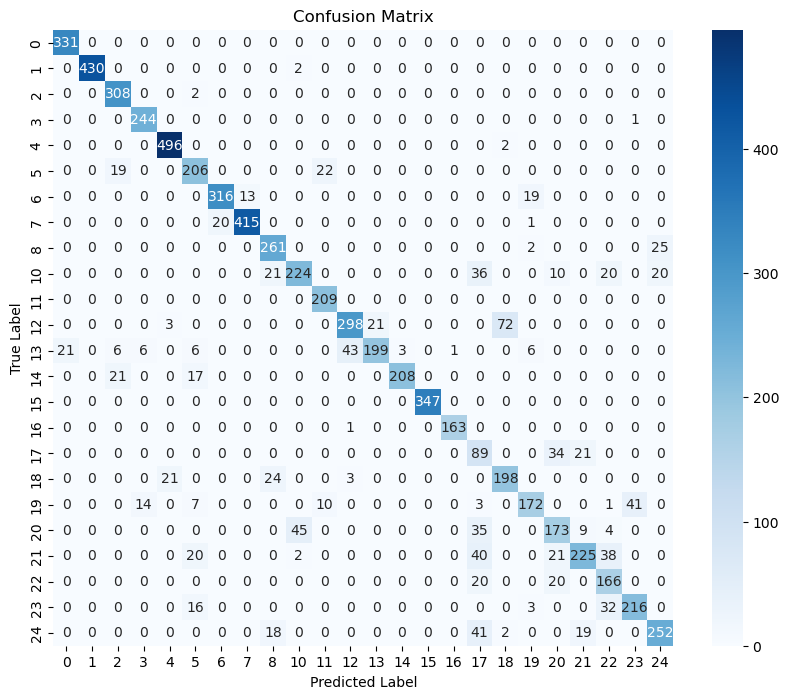

In [5]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=svm.classes_, yticklabels=svm.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### SVM - Discussion
As is evident from the get-go, SVM performs considerably better than K-Means and GMM. Especially with regards to GMM, our ARI was over 15 times higher. This is also evident with what we see in our classification report averages: our macro and weighted averages for precision, recall, and f1-score are relatively high, as well as our accuracy and confussion matrix. Of interesting note: label 17, or the letter "R", struggled a lot, with the lowest scores across all classification categories.

### Limitations
Are there any problems with the work?  For instance would more data change the nature of the problem? Would it be good to explore more hyperparams than you had time for?   

We wouldn't say that there were any inherent problems with the work, but we did have a feeling beforehand that the supervised algorithms would perform better than the unsupervised algorithms for our purposes (image recognition), but we were somewhat surprised at just how poorly they performed with our MNIST drop-in dataset. 

In this instance, we'd say that more data (at least, in regards to image recognition) would not change the nature of the problem. In most cases, CNN algorithms/CNN models will always have great performance at image recognition, as well as SVM (not to the same extent). Adding more data won't change the general predicted outcome.

We believe that exploring additional hyperparameters, had we had more time, would be interesting but wouldn't make a large difference in terms of model performance.

### Ethics & Privacy

Our American Sign Language recognition research project utilises the MNIST dataset of hand signs. Even though this dataset has been fairly corroborated and extensively updated over the years; since our project has an application in helping the "hard of hearing", it's necessary to consider some possible ethical concerns:

1. Clustering Algorithm Bias: The MNIST training data might lack diversity in hand shapes, skin tones, signing styles, or individual variations, resulting in the algorithm prioritising majority patterns, leading to inaccurate classifications for underrepresented groups. For instance, a dataset skewed towards younger signers might struggle with recognizing signs used more frequently by older adults. In addition to this, even with a perfect algorithm also, there might be implicit biases in the dataset which are being amplified by our clustering algorithm.For example, the data might contain more examples of right-handed signing, potentially impacting the model's ability to recognize signs performed with the left hand. While such conclusions are less often, they are important to take under consideration because the implications of such biases are significant. Misclassifications can lead to communication breakdowns, and misunderstandings, all of which on an extended period and a larger sample space may even lead to social exclusion for specific groups within the Deaf community. We aim to address these concerns by trialling and testing the usage of different clustering algorithms to mitigate the risk of false clustering. Hierarchical clustering, for instance, builds a hierarchy of clusters, allowing me to zoom in on specific signing styles or hand shapes potentially underrepresented in the data. Similarly, density-based methods like DBSCAN focus on identifying clusters based on data density, making them less susceptible to the influence of majority patterns that could amplify bias. By evaluating these alternative algorithms with diverse test sets and fairness metrics (accuracy, precision and F1 score), we will choose the model that best balances inclusivity and accuracy, ensuring equitable representation across all user groups.

2. Data Privacy Issue: The MNIST Hand Sign dataset we are utilising contains 27,455 cases of test data. These are real-life pictures collected from different thousands of different people. Now, in high-security stakes, hand-pictures also serve as identifiers. Due to this reason, similar to any other dataset, our MNIST ASL dataset is also subject to the protection of the privacy of individuals. In addition to this, we will also have input data from voluntary non-ASL communicators to test the real-time interpretation feature of the app. We hope to address this by keeping the identity of the volunteers undisclosed. In addition, we do it by utilising a "black-box" way of allowing the user to interact with the model. Without giving them any information about existing ASL hand signs, we hope to test the model for its accuracy in identifying any or all signs that people make, closest to an actual ASL sign.

### Conclusion

Reiterate your main point and in just a few sentences tell us how your results support it. Mention how this work would fit in the background/context of other work in this field if you can. Suggest directions for future work if you want to.

# Footnotes

<a name="onenote"></a>1.[^](#one): Ashley Chow, Glenn Cameron, Manfred Georg, Mark Sherwood, Phil Culliton, Sam Sepah, Sohier Dane, Thad Starner. (2023). Google - American Sign Language Fingerspelling Recognition. Kaggle. https://kaggle.com/competitions/asl-fingerspelling<br> 

<a name="twonote"></a>2.[^](#two): El Moujahid, K. (2021, December 1). Machine learning to make sign language more accessible. Google. https://blog.google/outreach-initiatives/accessibility/ml-making-sign-language-more-accessible/<br> 

<a name="threenote"></a>3.[^](#three): Garimella, M. (2022, August 23). Sign Language Recognition with Advanced Computer Vision. Medium. https://towardsdatascience.com/sign-language-recognition-with-advanced-computer-vision-7b74f20f3442<br> 

<a name="fournote"></a>4.[^](#four): tecperson. (October 2017). Sign Language MNIST. Kaggle. https://www.kaggle.com/datasets/datamunge/sign-language-mnist<br> 

<a name="fivenote"></a>5.[^](#five): Pathan, R. K., Biswas, M., Yasmin, S., Khandaker, M. U., Salman, M., & Youssef, A. A. F. (2023). Sign language recognition using the fusion of image and hand landmarks through multi-headed convolutional neural network. Scientific Reports, 13(1), 16975. https://doi.org/10.1038/s41598-023-43852-x<br> 

<a name="sixnote"></a>6.[^](#six): Chen, Y. (2023, December 29). Learning American Sign Language (ASL) with Google’s Teachable Machine: A No-Code Experiment. Medium. https://medium.com/@dynotes/breaking-barriers-using-googles-no-code-approach-for-sign-language-recognition-and-learning-fc92ae16522c#bypass<br> 

"<a name="MLTeaching"></a>7.[^](#MLTeachingNote) Google open Teachable Machine. https://teachablemachine.withgoogle.com/train/tiny_image"
